Get visual representation of how model accuracy does based on volatility of the ticker. 
- pull in apis
- get volatility score and volatility cat. at the end, i can put them on a scatterplot and have the color reflect category, x-axis reflect score. should be a positive correlation. 
- randomly get 30 tickers for each category. fit model and get metrics. 
    - use if statements

In [1]:
import requests
import yfinance as yf
import pandas as pd
import random
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

c:\Users\Shane\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get Ticker Metadata
# ------------------------------------------------------------------
FINNHUB_API_KEY = 'cuaq7shr01qof06j5bfgcuaq7shr01qof06j5bg0'
EXCHANGE_CODE = 'US' 

url = f'https://finnhub.io/api/v1/stock/symbol?exchange={EXCHANGE_CODE}&token={FINNHUB_API_KEY}'

try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    tickers_data = response.json()

    # Extract ticker symbols from the response
    tickers = [item['symbol'] for item in tickers_data] 

    print(tickers)

except requests.exceptions.RequestException as e:
    print(f"-- Error fetching data: {e} --")

['FDFF', 'SGBG', 'CMSA', 'BAUFF', 'ONPPF', 'OVM', 'GRN', 'STLXF', 'EFSCP', 'TGVSF', 'FNMAL', 'MWRDF', 'FYT', 'MRPZF', 'VERB', 'QQQE', 'SSTU', 'YJ', 'SOLU', 'RLFTY', 'WSTHF', 'MCRI', 'TSAT', 'HIPO', 'JSEJF', 'DLTA', 'RELI', 'YELLQ', 'KLXY', 'TXWHY', 'PMPG', 'WDCCF', 'LLKKF', 'BRKFF', 'AYASF', 'FQCC', 'CYPS', 'MUC', 'FRGE', 'CAOLF', 'GWTR', 'PLSVF', 'GHAV', 'RAJAF', 'NTDOY', 'WBBA', 'TOMDF', 'DTSQR', 'GEATF', 'CXAIW', 'SCTAY', 'LASMS', 'EGY', 'NNVC', 'NOVP', 'OACCW', 'MTMCF', 'GXG', 'RSCDS', 'HDLMY', 'EETH', 'SDPNF', 'CECBW', 'PCIMF', 'SPXXF', 'TSSHF', 'AQUNU', 'TMKEF', 'TMFS', 'FSK', 'FDGR', 'SICLQ', 'ILCG', 'DSY', 'QQH', 'ADKIL', 'TDNT', 'AUGG', 'NEFB', 'WSFL', 'XTKRF', 'KWPCF', 'NGL.PRC', 'ARGHF', 'OARFF', 'OLED', 'CUE', 'SHALY', 'VRMMQ', 'LZM.WS', 'CNLK', 'MRGIF', 'EDNMY', 'NKE', 'RFEM', 'DOYNF', 'NMRD', 'VLCJF', 'NCNA', 'CMSC', 'FUPPF', 'RTWDS', 'GEDSF', 'BIOIF', 'CDNAF', 'BLMS', 'AAIGF', 'NAUBF', 'AMKYF', 'KMT', 'PEYEF', 'AVA', 'ZVSA', 'FKWL', 'MTR', 'TVBCF', 'GNGBY', 'NSAV', 'WSO.

In [3]:
def load_data(ticker):
    """
    Downloads historical market data for a given ticker symbol.

    Parameters:
    ticker (str): The ticker symbol of the stock to download data for.

    Returns:
    pd.DataFrame: A DataFrame containing the historical market data for the specified ticker.
    """
    data = yf.download(ticker, period='max') # returns relevant data in df
    data.reset_index(inplace=True) # reset multindex, output is index list of tuples
    cols = list(data.columns) # convert index to list
    cols[0] = ('Date', '') 
    cols = [i[0] for i in cols] # return first element of cols tuples
    data.columns = cols # set as column names
    data['Date'] = pd.to_datetime(data['Date']).dt.date
    return data

In [4]:
category_ct_dict = {
    'Low': 0,
    'Medium-Low': 0,
    'Medium': 0,
    'Medium-High': 0,
    'High': 0
}

In [5]:
def get_volatility(data):
    volatility = data.daily_returns.std() * np.sqrt(252)
    if volatility < 0.2:
        category = "Low"
    elif volatility < 0.4:
        category = "Medium-Low"
    elif volatility < 0.6:
        category = "Medium"
    elif volatility < 0.8:
        category = "Medium-High"
    else:
        category = "High"
    return category, volatility

In [6]:
def get_period_params(data, volatility):
    if len(data)/365 < 8:
        period_unit = int(len(data)/4)
        forecast_period = period_unit
        train_period = len(data)
    else:
        period_unit = 365
        forecast_period = period_unit
        train_period = forecast_period * 4 if volatility < 0.6 else forecast_period * 8
    return train_period, period_unit, forecast_period

In [7]:
cv_func = lambda model_name, train_period, period_unit, forecast_period: cross_validation(model_name, 
                                              initial=f'{train_period} days', 
                                              period=f'{period_unit} days', 
                                              horizon=f'{forecast_period} days', 
                                              parallel="processes")

In [8]:
len_tickers = len(tickers)

In [ ]:
def validity_check(data):
    """
    data must be at least 1 year old, at least $10, and have an average volume of at least 100,000
    """
    return (len(data) > 365) \
        and (data.Close.mean() >= 10).item() \
            and (data['Volume'].rolling(window=20).mean().iloc[-1] >= 100000).item()

In [ ]:
def score_ticker_rmses():
    rmses = []
    tickers_modeled = []
    volatility_list = []
    avg_price_list = []
    len_list = []
    while True:
        category, volatility = '', 0
        ticker_n = random.randint(0, len(tickers))
        ticker_to_model = tickers.pop(ticker_n) # .pop() ensures that the ticker is removed from the list
        data = yf.download(ticker_to_model, period='max')
        if validity_check(data):
            data = load_data(ticker_to_model)
        else:
            continue
        data['daily_returns'] = data.Close.pct_change() # add to return
        category, volatility = get_volatility(data)
        if category_ct_dict[category] < 30:
            tickers_modeled.append(ticker_to_model)
            volatility_list.append(category)
            avg_price_list.append(data.Close.mean())
            len_list.append(len(data))
            category_ct_dict[category] += 1
            train_period, period_unit, forecast_period = get_period_params(data, volatility)
            df_train = data[['Date', 'Close']].iloc[-train_period:]
            df_train.columns = ['ds', 'y']
            m = Prophet().fit(df_train)
            df_cv = cv_func(m, train_period, period_unit, forecast_period)
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])
        if all(value >= 30 for value in category_ct_dict.values()):
            break 
    return rmses, tickers_modeled, volatility_list, avg_price_list, len_list

In [14]:
rmses, tickers_modeled, volatility_list, avg_price_list, len_list = score_ticker_rmses()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
19:06:51 - cmdstanpy - INFO - Chain [1] start processing
19:06:52 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
19:06:54 - cmdstanpy - INFO - Chain [1] start processing
19:06:54 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[**************

In [15]:
category_ct_dict

{'Low': 30, 'Medium-Low': 30, 'Medium': 30, 'Medium-High': 30, 'High': 30}

In [16]:
len(tickers_modeled)

150

In [17]:
len(rmses)

150

In [18]:
len(volatility_list)

150

In [19]:
df = pd.DataFrame({
    'ticker': tickers_modeled, 
    'volatility': volatility_list, 
    'rmse': rmses, 
    'avg_price': avg_price_list, 
    'len': len_list
    })
df.head()

,ticker,volatility,rmse,avg_price,len
0,ADYEY,Medium,5.087750,16.389898,1347
1,NMM,Medium,23.137863,63.829555,4339
2,MARK,High,10.280774,214.811263,5455
3,VIGI,Low,12.586773,63.282331,2251
4,GDRX,Medium-High,2.904431,17.561466,1102


In [20]:
df.volatility.value_counts()

volatility
Medium         30
High           30
Low            30
Medium-High    30
Medium-Low     30
Name: count, dtype: int64

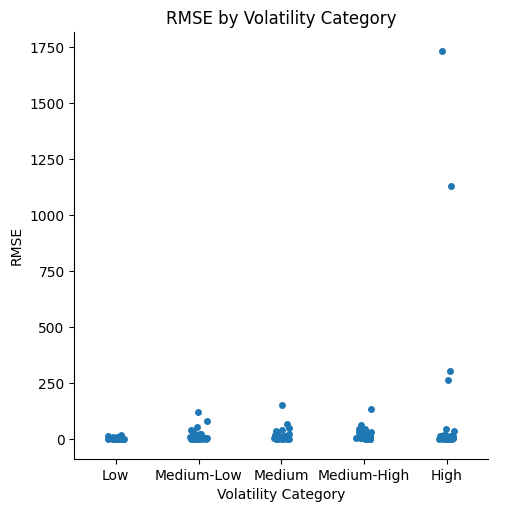

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'] 

# Create the catplot
sns.catplot(x='volatility', y='rmse', data=df, kind='strip', order=order) 

# Customize the plot (optional)
plt.xlabel('Volatility Category')
plt.ylabel('RMSE')
plt.title('RMSE by Volatility Category')

# Show the plot
plt.show()

In [22]:
high_volatility = df[df['volatility'] == 'High']
high_volatility.sort_values('rmse', ascending=False)

,ticker,volatility,rmse,avg_price,len
115,ACON,High,1731.085986,2.609748e+03,704
32,GMPR,High,1132.136650,1.778608e+11,7481
42,RELI,High,303.066552,3.768767e+02,1007
119,PDPR,High,263.618164,4.118486e+02,1454
38,VINC,High,44.664846,1.200018e+02,1185
91,STRL,High,37.479354,1.443581e+01,8458
10,AAOI,High,20.194137,1.741556e+01,2862
61,SGBX,High,19.781879,2.139745e+02,1921
39,VERV,High,15.274003,2.122246e+01,918
112,APM,High,14.006823,4.456068e+01,1546


In [23]:
filtered_df = df[df['volatility'] != 'High']
filtered_df.volatility.value_counts()

volatility
Medium         30
Low            30
Medium-High    30
Medium-Low     30
Name: count, dtype: int64

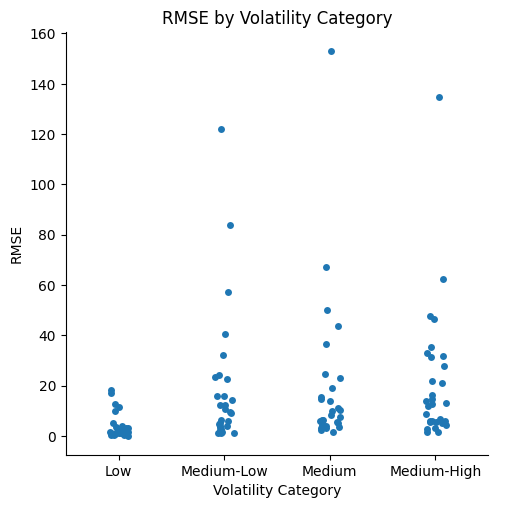

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ['Low', 'Medium-Low', 'Medium', 'Medium-High'] 

# Create the catplot
sns.catplot(x='volatility', y='rmse', data=filtered_df, kind='strip', order=order) 

# Customize the plot (optional)
plt.xlabel('Volatility Category')
plt.ylabel('RMSE')
plt.title('RMSE by Volatility Category')

# Show the plot
plt.show()

In [25]:
# save data manually to csv

standard_model_path = r"C:\Users\Shane\Desktop\2024.06.27_-_Data_Science\2024.10.13 - Portfolio Projects\2024.12.04 - Swing Ticker\Model Performance"

In [26]:
df.to_csv(standard_model_path + r"\standard_model.csv", index=False)